In [53]:
pip install tld

In [54]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from tld import get_tld, is_tld

In [55]:
import pandas as pd

# Load CSV
df = pd.read_csv("/content/malicious_phish.csv")

# Check the data
print(df.head())

                                                 url        type
0                                   br-icloud.com.br    phishing
1                mp3raid.com/music/krizz_kaliko.html      benign
2                    bopsecrets.org/rexroth/cr/1.htm      benign
3  http://www.garage-pirenne.be/index.php?option=...  defacement
4  http://adventure-nicaragua.net/index.php?optio...  defacement


In [56]:
print(df.info)

#checking for NaN values
df.isnull().sum()
print("count of data values:")
count = df.type.value_counts()
print(count)

<bound method DataFrame.info of                                                       url        type
0                                        br-icloud.com.br    phishing
1                     mp3raid.com/music/krizz_kaliko.html      benign
2                         bopsecrets.org/rexroth/cr/1.htm      benign
3       http://www.garage-pirenne.be/index.php?option=...  defacement
4       http://adventure-nicaragua.net/index.php?optio...  defacement
...                                                   ...         ...
651186            xbox360.ign.com/objects/850/850402.html    phishing
651187       games.teamxbox.com/xbox-360/1860/Dead-Space/    phishing
651188         www.gamespot.com/xbox360/action/deadspace/    phishing
651189      en.wikipedia.org/wiki/Dead_Space_(video_game)    phishing
651190          www.angelfire.com/goth/devilmaycrytonite/    phishing

[651191 rows x 2 columns]>
count of data values:
type
benign        428103
defacement     96457
phishing       94111
malware   

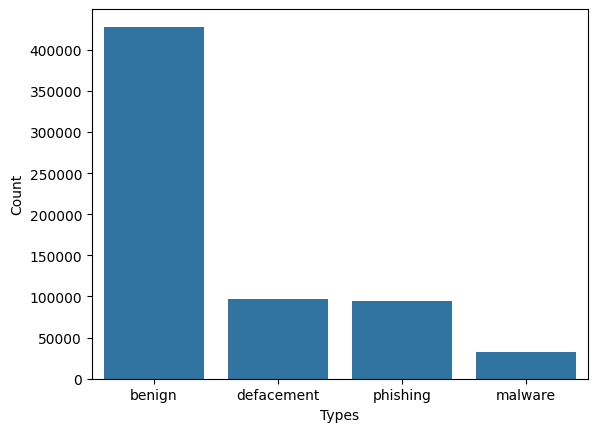

In [57]:
sns.barplot(x=count.index, y=count)
plt.xlabel('Types')
plt.ylabel('Count');

Have to omit www. from any url

In [58]:
df['url'] = df['url'].replace('www.', '', regex=True)
print(df)

                                                      url        type
0                                        br-icloud.com.br    phishing
1                     mp3raid.com/music/krizz_kaliko.html      benign
2                         bopsecrets.org/rexroth/cr/1.htm      benign
3       http://garage-pirenne.be/index.php?option=com_...  defacement
4       http://adventure-nicaragua.net/index.php?optio...  defacement
...                                                   ...         ...
651186            xbox360.ign.com/objects/850/850402.html    phishing
651187       games.teamxbox.com/xbox-360/1860/Dead-Space/    phishing
651188             gamespot.com/xbox360/action/deadspace/    phishing
651189      en.wikipedia.org/wiki/Dead_Space_(video_game)    phishing
651190              angelfire.com/goth/devilmaycrytonite/    phishing

[651191 rows x 2 columns]


We'll convert URLs into numeric features the model can use.

In [73]:
rem = {"Category": {"benign": 0, "defacement": 1, "phishing":2, "malware":3}}
df['Category'] = df['type']
df = df.replace(rem)

<ipython-input-73-11106f3a28eb>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(rem)


In [59]:
df['url_len'] = df['url'].apply(lambda x: len(str(x)))

def process_tld(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain

df['domain'] = df['url'].apply(lambda i: process_tld(i))
print(df.head())

                                                 url        type  url_len  \
0                                   br-icloud.com.br    phishing       16   
1                mp3raid.com/music/krizz_kaliko.html      benign       35   
2                    bopsecrets.org/rexroth/cr/1.htm      benign       31   
3  http://garage-pirenne.be/index.php?option=com_...  defacement       84   
4  http://adventure-nicaragua.net/index.php?optio...  defacement      235   

                    domain  
0         br-icloud.com.br  
1              mp3raid.com  
2           bopsecrets.org  
3        garage-pirenne.be  
4  adventure-nicaragua.net  


In [60]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    df[a] = df['url'].apply(lambda i: i.count(a))

In [61]:
print(df.head())

                                                 url        type  url_len  \
0                                   br-icloud.com.br    phishing       16   
1                mp3raid.com/music/krizz_kaliko.html      benign       35   
2                    bopsecrets.org/rexroth/cr/1.htm      benign       31   
3  http://garage-pirenne.be/index.php?option=com_...  defacement       84   
4  http://adventure-nicaragua.net/index.php?optio...  defacement      235   

                    domain  @  ?  -  =  .  #  %  +  $  !  *  ,  //  
0         br-icloud.com.br  0  0  1  0  2  0  0  0  0  0  0  0   0  
1              mp3raid.com  0  0  0  0  2  0  0  0  0  0  0  0   0  
2           bopsecrets.org  0  0  0  0  2  0  0  0  0  0  0  0   0  
3        garage-pirenne.be  0  1  1  4  2  0  0  0  0  0  0  0   1  
4  adventure-nicaragua.net  0  1  1  3  2  0  0  0  0  0  0  0   1  


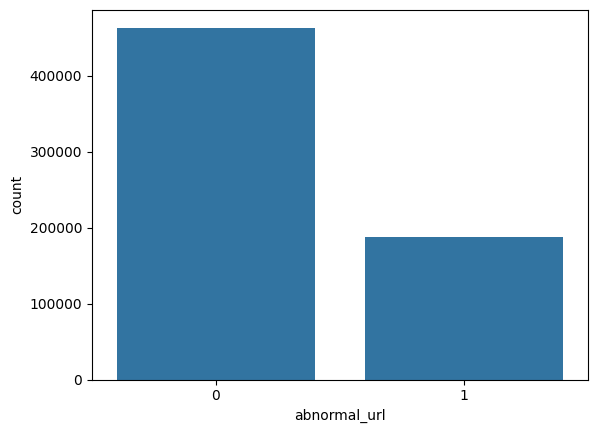

In [62]:
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))
sns.countplot(x='abnormal_url', data=df);

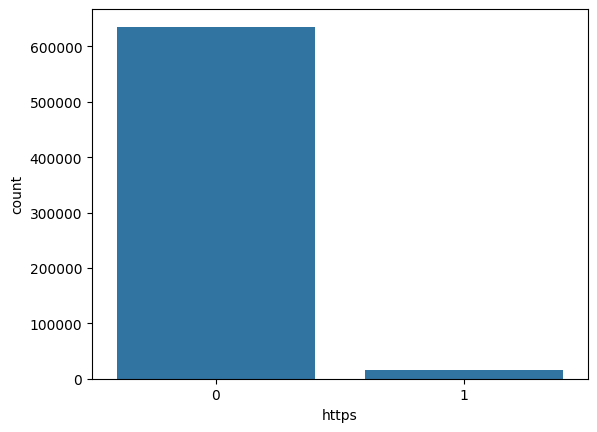

In [63]:
def httpSecure(url):
    htp = urlparse(url).scheme
    match = str(htp)
    if match=='https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

df['https'] = df['url'].apply(lambda i: httpSecure(i))
sns.countplot(x='https', data=df);

In [64]:
#count no.of digit characters

def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

df['digits']= df['url'].apply(lambda i: digit_count(i))

#count no.of letter characters

def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

df['letters']= df['url'].apply(lambda i: letter_count(i))

Check if URL has shorting service applied

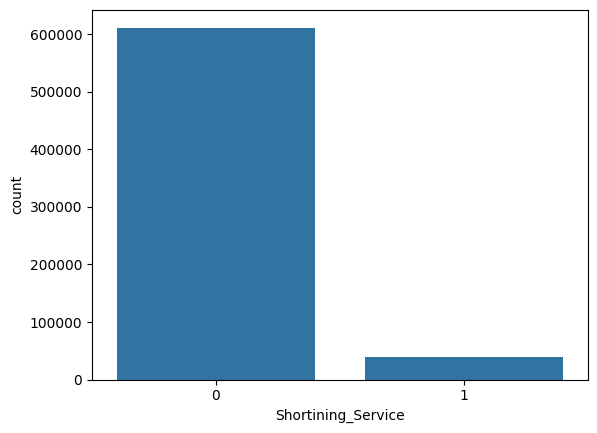

In [65]:
def Shortining_Service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

df['Shortining_Service'] = df['url'].apply(lambda x: Shortining_Service(x))
sns.countplot(x='Shortining_Service', data=df);


In [66]:
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

df['having_ip_address'] = df['url'].apply(lambda i: having_ip_address(i))
df['having_ip_address'].value_counts()

,count
having_ip_address,
0,638703
1,12488


In [74]:
features_df = df.drop(['url','type','Category','domain'],axis=1)
labels = df['Category']

print(features_df)

                                                      url        type  \
0                                        br-icloud.com.br    phishing   
1                     mp3raid.com/music/krizz_kaliko.html      benign   
2                         bopsecrets.org/rexroth/cr/1.htm      benign   
3       http://garage-pirenne.be/index.php?option=com_...  defacement   
4       http://adventure-nicaragua.net/index.php?optio...  defacement   
...                                                   ...         ...   
651186            xbox360.ign.com/objects/850/850402.html    phishing   
651187       games.teamxbox.com/xbox-360/1860/Dead-Space/    phishing   
651188             gamespot.com/xbox360/action/deadspace/    phishing   
651189      en.wikipedia.org/wiki/Dead_Space_(video_game)    phishing   
651190              angelfire.com/goth/devilmaycrytonite/    phishing   

        url_len                   domain  @  ?  -  =  .  #  ...  *  ,  //  \
0            16         br-icloud.com.br  0  0

Train model (RandomForestClassifier from sklearn)

In [75]:
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(features_df, labels, test_size=0.2, random_state=42)

# Check if any cell in X_train is a dictionary
print(X_train.applymap(type).eq(dict).any())


<ipython-input-75-9e601e901377>:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(X_train.applymap(type).eq(dict).any())


url_len               False
@                     False
?                     False
-                     False
=                     False
.                     False
#                     False
%                     False
+                     False
$                     False
!                     False
*                     False
,                     False
//                    False
abnormal_url          False
https                 False
digits                False
letters               False
Shortining_Service    False
having_ip_address     False
dtype: bool


**Run below cell if found any value to be true in above output.**

In [ ]:
# Expand the 'features' column which contains dictionaries
#features_df = pd.json_normalize(X_train['features'])

# Drop the original 'features' column and join the new columns
#X_train = X_train.drop(columns=['features']).join(features_df)

#print(X_train.applymap(type).eq(dict).any())  # should all be False now

#----------for test data -------------
# Step 1: Expand the 'features' dict column in X_test
#features_test_df = pd.json_normalize(X_test['features'])

# Step 2: Drop the original 'features' column and join expanded features
#X_test = X_test.drop(columns=['features']).join(features_test_df)

# Step 3: Make sure column order matches X_train
#X_test = X_test[X_train.columns]


######-Model => <class 'sklearn.ensemble._forest.RandomForestClassifier'> 
Accuracy: 0.9140580010595905
              Classification_report 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     85778
           1       0.93      0.97      0.95     19104
           2       0.83      0.57      0.68     18836
           3       0.95      0.91      0.93      6521

    accuracy                           0.91    130239
   macro avg       0.91      0.86      0.88    130239
weighted avg       0.91      0.91      0.91    130239

             Confusion_matrix 


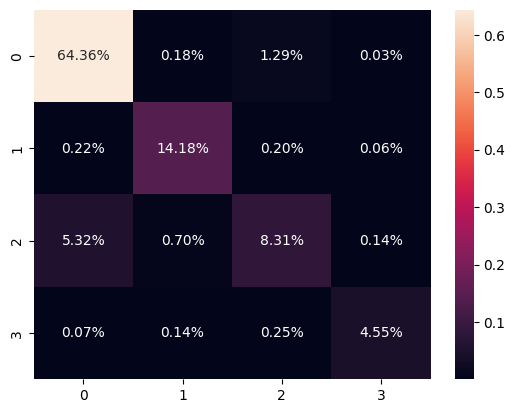

In [76]:
print('######-Model =>\033[07m {} \033[0m'.format(RandomForestClassifier))
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Predict
predictions = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))

print('\033[01m              Classification_report \033[0m')
print(classification_report(y_test, predictions))
print('\033[01m             Confusion_matrix \033[0m')
cf_matrix = confusion_matrix(y_test, predictions)
plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%')
plt.show()

save model

In [77]:
import joblib

# Save the model
joblib.dump(model, 'url_model.joblib')

# Save the feature column names (list of feature names used in training)
joblib.dump(features_df.columns.tolist(), 'model_features.joblib')


['model_features.joblib']